In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor



In [2]:
df = pd.read_csv('modified_cropyield.csv')
df.head(3)

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Yield_tons_per_hectare,N,P,K,ph
0,South,Clay,Rice,992.673282,18.026142,True,True,8.527341,227.856348,18.632321,187.383842,8.392863
1,North,Loam,Barley,147.998025,29.794042,False,False,1.127443,156.926335,9.845947,169.432720,7.104303
2,North,Sandy,Soybean,986.866331,16.644190,False,True,6.517573,163.751011,9.815127,175.853055,6.133666


In [ ]:
maize_df = df[df['Crop'] == 'Maize'] 

print(maize_df.head())
print(f"Total maize rows: {len(maize_df)}")

   Region Soil_Type   Crop  Rainfall_mm  Temperature_Celsius  Fertilizer_Used  \
15  South      Clay  Maize   888.207630            39.945509             True   
19   East    Chalky  Maize   170.814456            29.116377            False   
22  South      Silt  Maize   259.418125            17.261892            False   
24   East      Silt  Maize   609.798764            38.265851             True   
30   East      Clay  Maize   599.875493            19.909292             True   

    Irrigation_Used  Yield_tons_per_hectare           N          P  \
15            False                7.173037  180.761136  23.165463   
19             True                2.332255   39.123211   4.681515   
22            False                2.338541  210.660762  15.051945   
24            False                5.113588  209.979415  10.126888   
30            False                4.696425  209.126156  11.822895   

             K        ph  
15  196.901922  7.279124  
19  141.544043  7.889149  
22  220.508

In [4]:
maize_df = maize_df.drop('Crop', axis=1)
print(maize_df.columns)
df=maize_df


Index(['Region', 'Soil_Type', 'Rainfall_mm', 'Temperature_Celsius',
       'Fertilizer_Used', 'Irrigation_Used', 'Yield_tons_per_hectare', 'N',
       'P', 'K', 'ph'],
      dtype='object')


In [ ]:
categorical_cols = ['Region', 'Soil_Type', 'Fertilizer_Used', 'Irrigation_Used']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [6]:
with open('label_encoders_maize.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

In [7]:
df.head(1)

,Region,Soil_Type,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Yield_tons_per_hectare,N,P,K,ph
15,2,1,888.20763,39.945509,1,0,7.173037,180.761136,23.165463,196.901922,7.279124


In [8]:
X = df.drop('Yield_tons_per_hectare', axis=1)
y = df['Yield_tons_per_hectare']

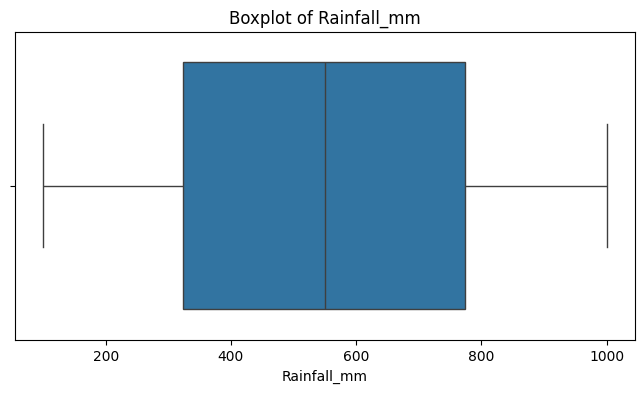

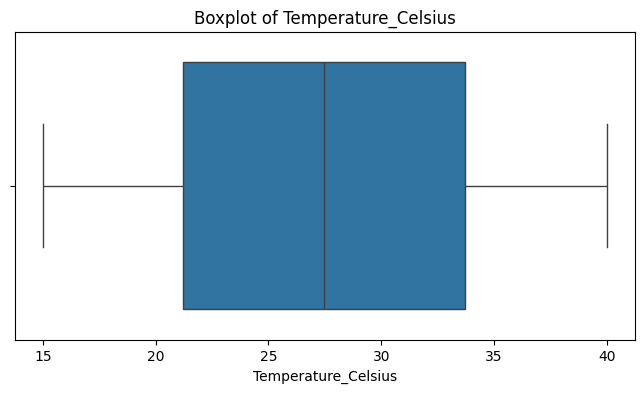

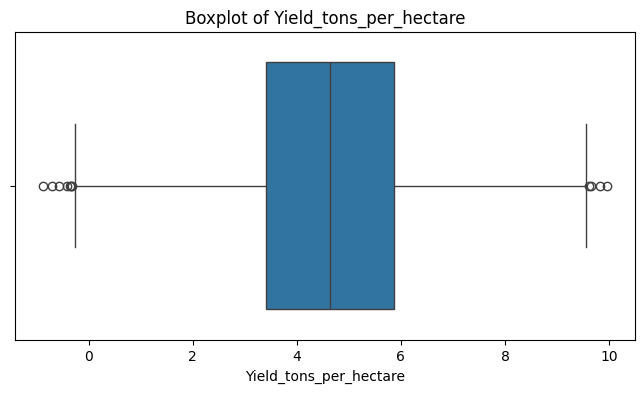

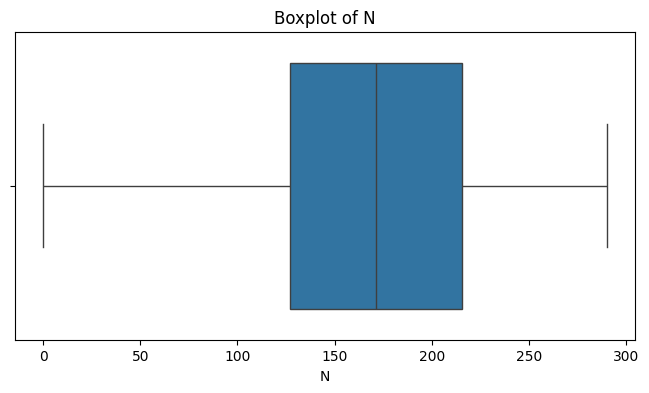

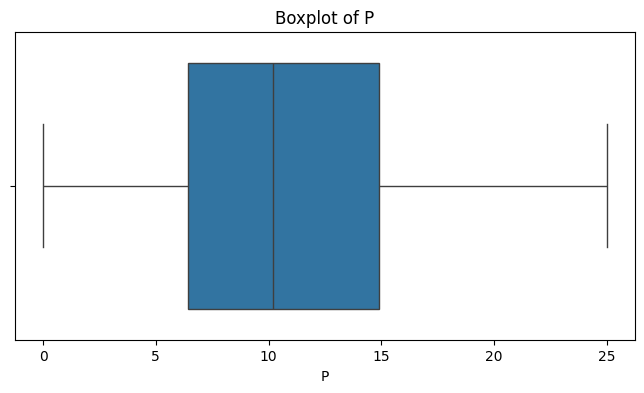

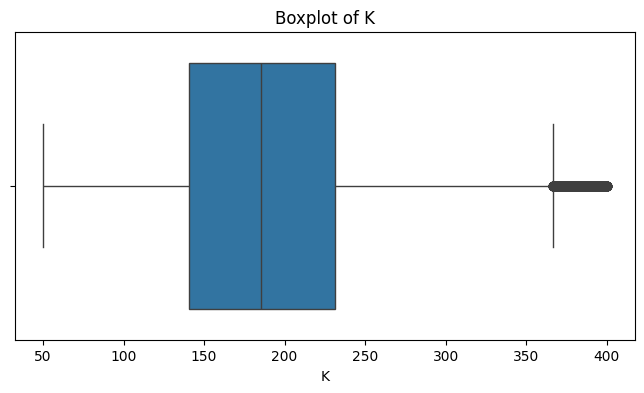

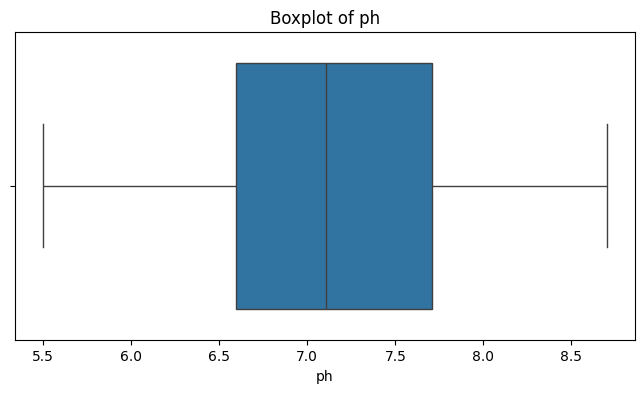

Number of outliers in 'K': 3611
Number of outliers in 'Yield_tons_per_hectare': 11


In [ ]:
numeric_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Yield_tons_per_hectare', 'N', 'P', 'K', 'ph']

#Boxplots for numerical variables
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers.count()

print("Number of outliers in 'K':", count_outliers_iqr(df['K']))
print("Number of outliers in 'Yield_tons_per_hectare':", count_outliers_iqr(df['Yield_tons_per_hectare']))

In [10]:
df['K_bin'] = pd.qcut(df['K'], q=4, labels=False)
df['yield_bin'] = pd.qcut(df['Yield_tons_per_hectare'], q=4, labels=False)
df['strat_bin'] = df['K_bin'].astype(str) + '_' + df['yield_bin'].astype(str)

df_train_val, df_test = train_test_split(df, test_size=0.15, stratify=df['strat_bin'], random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=0.1765, stratify=df_train_val['strat_bin'], random_state=42)

# Drop auxiliary columns
df_train = df_train.drop(columns=['K_bin', 'yield_bin', 'strat_bin'])
df_val = df_val.drop(columns=['K_bin', 'yield_bin', 'strat_bin'])
df_test = df_test.drop(columns=['K_bin', 'yield_bin', 'strat_bin'])

X_train = df_train.drop('Yield_tons_per_hectare', axis=1)
y_train = df_train['Yield_tons_per_hectare']
X_val = df_val.drop('Yield_tons_per_hectare', axis=1)
y_val = df_val['Yield_tons_per_hectare']
X_test = df_test.drop('Yield_tons_per_hectare', axis=1)
y_test = df_test['Yield_tons_per_hectare']


print("X_train:", X_train.shape, " | y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   " | y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  " | y_test:", y_test.shape)

X_train: (116772, 10)  | y_train: (116772,)
X_val:   (25028, 10)  | y_val:   (25028,)
X_test:  (25024, 10)  | y_test: (25024,)


In [13]:
X_train.head(1)

,Region,Soil_Type,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,N,P,K,ph
374975,3,3,860.143523,29.950568,0,1,182.355911,11.219605,103.479915,6.265023


In [14]:
y_train.head(1)

374975    6.679524
Name: Yield_tons_per_hectare, dtype: float64

In [ ]:
rf_model2 = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model2.fit(X_train, y_train)


def print_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    std_err = np.std(y_true - y_pred)
    print(f"{dataset_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, Std Err: {std_err:.4f}")

y_train_pred = rf_model2.predict(X_train)
y_val_pred = rf_model2.predict(X_val)
y_test_pred = rf_model2.predict(X_test)

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")
# # rf
# Train - R2: 0.9870, RMSE: 0.1935, MSE: 0.0374, MAE: 0.1531, Std Err: 0.1935
# Validation - R2: 0.9080, RMSE: 0.5163, MSE: 0.2665, MAE: 0.4123, Std Err: 0.5163
# Test - R2: 0.9072, RMSE: 0.5144, MSE: 0.2647, MAE: 0.4113, Std Err: 0.5144


Train - R2: 0.9870, RMSE: 0.1935, MSE: 0.0374, MAE: 0.1531, Std Err: 0.1935
Validation - R2: 0.9080, RMSE: 0.5163, MSE: 0.2665, MAE: 0.4123, Std Err: 0.5163
Test - R2: 0.9072, RMSE: 0.5144, MSE: 0.2647, MAE: 0.4113, Std Err: 0.5144


In [ ]:
# hyper param for rf
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)

random_search.fit(X_train, y_train)
#already found dont run
print("Best parameters:", random_search.best_params_)

In [ ]:
best_params = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 30,
    'random_state': 42
}

best_rf_model = RandomForestRegressor(**best_params)
best_rf_model.fit(X_train, y_train)

y_train_pred = best_rf_model.predict(X_train)
y_val_pred = best_rf_model.predict(X_val)
y_test_pred = best_rf_model.predict(X_test)

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")
# # rf_tuned : 
# Train - R2: 0.9550, RMSE: 0.3597, MSE: 0.1294, MAE: 0.2824, Std Err: 0.3597
# Validation - R2: 0.9113, RMSE: 0.5070, MSE: 0.2570, MAE: 0.4052, Std Err: 0.5070
# Test - R2: 0.9101, RMSE: 0.5062, MSE: 0.2562, MAE: 0.4046, Std Err: 0.5062

Train - R2: 0.9550, RMSE: 0.3597, MSE: 0.1294, MAE: 0.2824, Std Err: 0.3597
Validation - R2: 0.9113, RMSE: 0.5070, MSE: 0.2570, MAE: 0.4052, Std Err: 0.5070
Test - R2: 0.9101, RMSE: 0.5062, MSE: 0.2562, MAE: 0.4046, Std Err: 0.5062


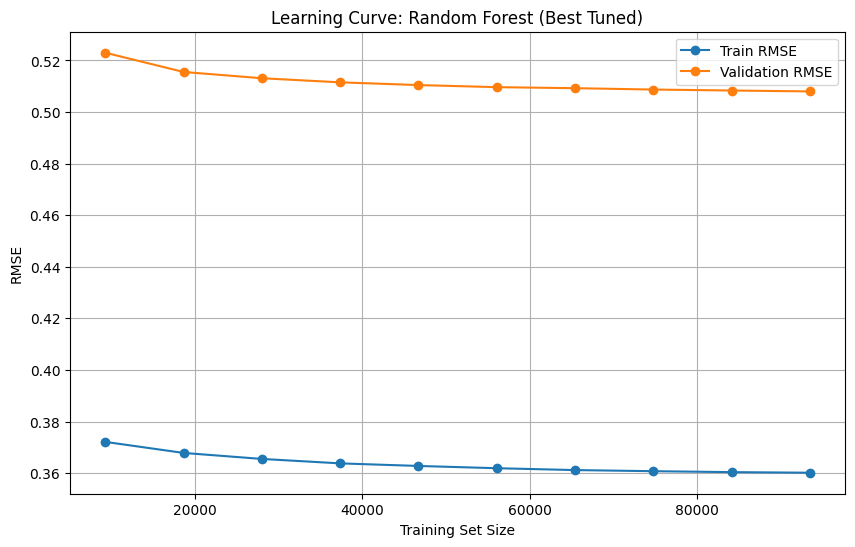

In [18]:
def rmse_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred))

train_sizes, train_scores, val_scores = learning_curve(
    best_rf_model,
    X_train,
    y_train,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_rmse, label="Train RMSE", marker='o')
plt.plot(train_sizes, val_rmse, label="Validation RMSE", marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve: Random Forest (Best Tuned)")
plt.legend()
plt.grid(True)
plt.show()

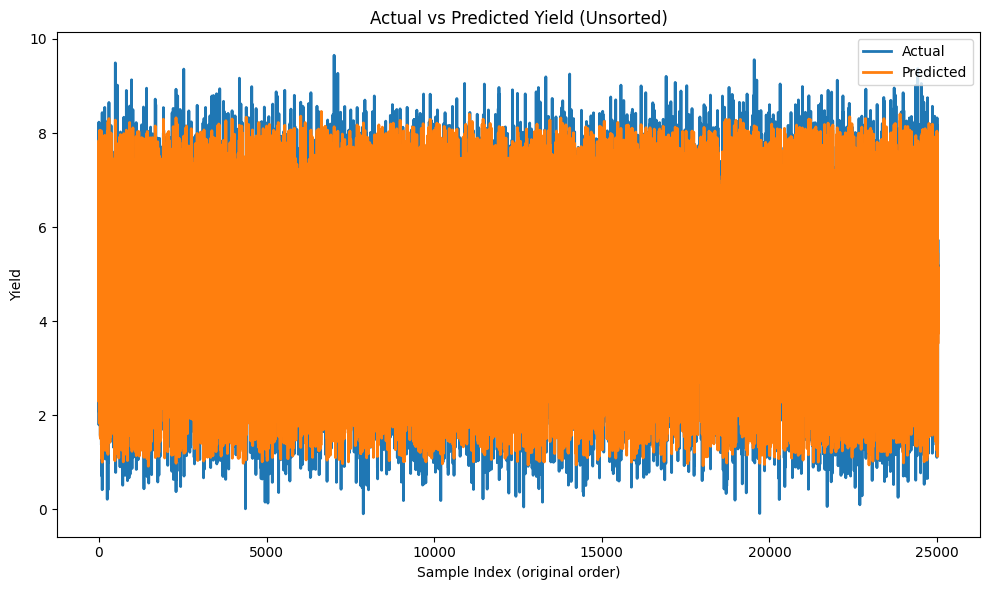

In [ ]:
y_val_pred = best_rf_model.predict(X_val)

plt.figure(figsize=(10, 6))
plt.plot(y_val.values, label='Actual', linewidth=2)
plt.plot(y_val_pred, label='Predicted', linewidth=2)
plt.xlabel('Sample Index (original order)')
plt.ylabel('Yield')
plt.title('Actual vs Predicted Yield (Unsorted)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
best_params_ada = {
    'learning_rate': 1.0,
    'loss': 'square',
    'n_estimators': 200,
    'random_state': 42
}

best_ada = AdaBoostRegressor(**best_params_ada)
best_ada.fit(X_train, y_train)

def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    sd = np.std(y_true - y_pred)
    print(f"{dataset_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, SD: {sd:.4f}")

print_metrics(y_train, best_ada.predict(X_train), "Train")
print_metrics(y_val, best_ada.predict(X_val), "Validation")
print_metrics(y_test, best_ada.predict(X_test), "Test")


# # Best AdaBoost params: {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 200}
# # Ada_tuned:
# Train - R2: 0.8883, RMSE: 0.5668, MAE: 0.4531, MSE: 0.3213, SD: 0.5667
# Validation - R2: 0.8883, RMSE: 0.5688, MAE: 0.4538, MSE: 0.3235, SD: 0.5685
# Test - R2: 0.8879, RMSE: 0.5655, MAE: 0.4527, MSE: 0.3197, SD: 0.5653

Train - R2: 0.8883, RMSE: 0.5668, MAE: 0.4531, MSE: 0.3213, SD: 0.5667
Validation - R2: 0.8883, RMSE: 0.5688, MAE: 0.4538, MSE: 0.3235, SD: 0.5685
Test - R2: 0.8879, RMSE: 0.5655, MAE: 0.4527, MSE: 0.3197, SD: 0.5653


In [ ]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42
)

# Fit model
gb_model.fit(X_train, y_train)

def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    sd = np.std(y_true - y_pred)
    print(f"{dataset_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, SD: {sd:.4f}")

print_metrics(y_train, gb_model.predict(X_train), "Train")
print_metrics(y_val, gb_model.predict(X_val), "Validation")
print_metrics(y_test, gb_model.predict(X_test), "Test")

# Gb_boost:
# Train - R2: 0.9132, RMSE: 0.4998, MAE: 0.3988, MSE: 0.2498, SD: 0.4998
# Validation - R2: 0.9131, RMSE: 0.5018, MAE: 0.4007, MSE: 0.2518, SD: 0.5018
# Test - R2: 0.9120, RMSE: 0.5008, MAE: 0.3998, MSE: 0.2508, SD: 0.5008

Train - R2: 0.9132, RMSE: 0.4998, MAE: 0.3988, MSE: 0.2498, SD: 0.4998
Validation - R2: 0.9131, RMSE: 0.5018, MAE: 0.4007, MSE: 0.2518, SD: 0.5018
Test - R2: 0.9120, RMSE: 0.5008, MAE: 0.3998, MSE: 0.2508, SD: 0.5008


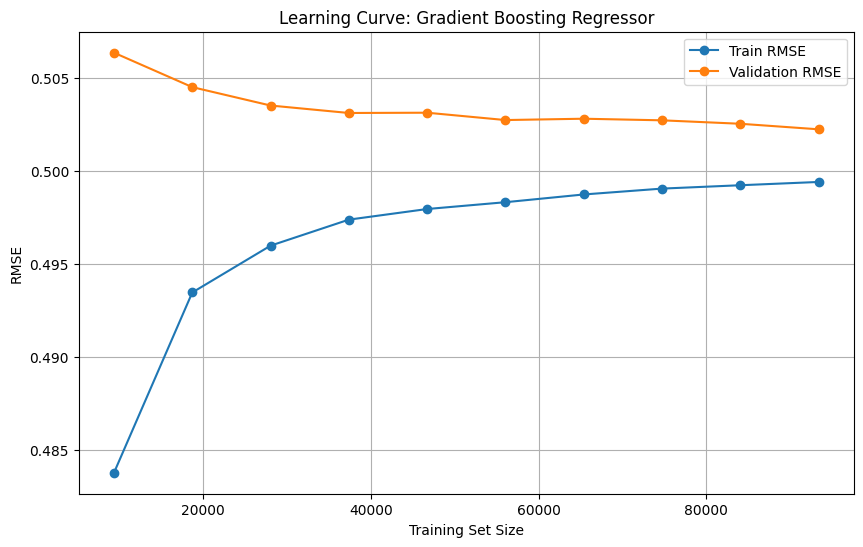

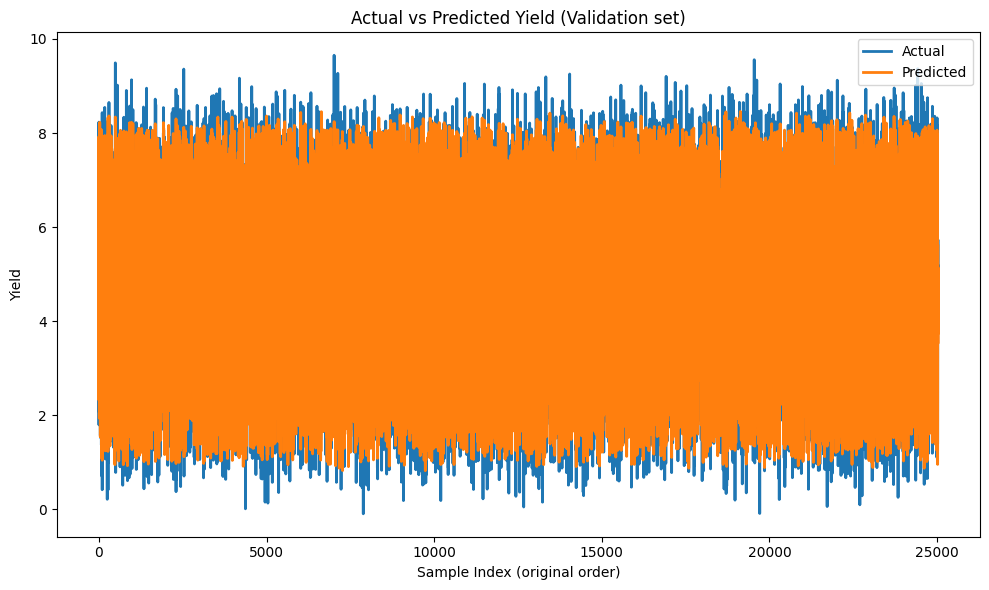

In [ ]:
def rmse_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred))

train_sizes, train_scores, val_scores = learning_curve(
    gb_model,
    X_train,
    y_train,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, label='Train RMSE', marker='o')
plt.plot(train_sizes, val_rmse, label='Validation RMSE', marker='o')
plt.title('Learning Curve: Gradient Boosting Regressor')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Actual vs Predicted plot on validation set
y_val_pred = gb_model.predict(X_val)

plt.figure(figsize=(10, 6))
plt.plot(y_val.values, label='Actual', linewidth=2)
plt.plot(y_val_pred, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Yield (Validation set)')
plt.xlabel('Sample Index (original order)')
plt.ylabel('Yield')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
with open('gb_model_maize.pkl', 'wb') as f:
    pickle.dump(gb_model, f)

print("Models and encoders saved successfully.")

Models and encoders saved successfully.


In [ ]:
input_data = {
    'Region': [1],
    'Soil_Type': [5],
    'Rainfall_mm': [689.113795],
    'Temperature_Celsius': [25.801389],
    'Fertilizer_Used': [1],
    'Irrigation_Used': [1],
    'N': [246.886589],
    'P': [15.363449],
    'K': [173.453087],
    'ph': [7.410310]
}

input_df = pd.DataFrame(input_data)

prediction = gb_model.predict(input_df)
print("Predicted Yield:", prediction[0])
#  3.722298 actual

# rf_model2 : Predicted Yield: 3.999989528286017
# best_rf_model: Predicted Yield: 4.083936596435578
# best_ada : Predicted Yield: 3.4746255177717034
# gb_model : Predicted Yield: 3.945270287487772

Predicted Yield: 6.632252050340603


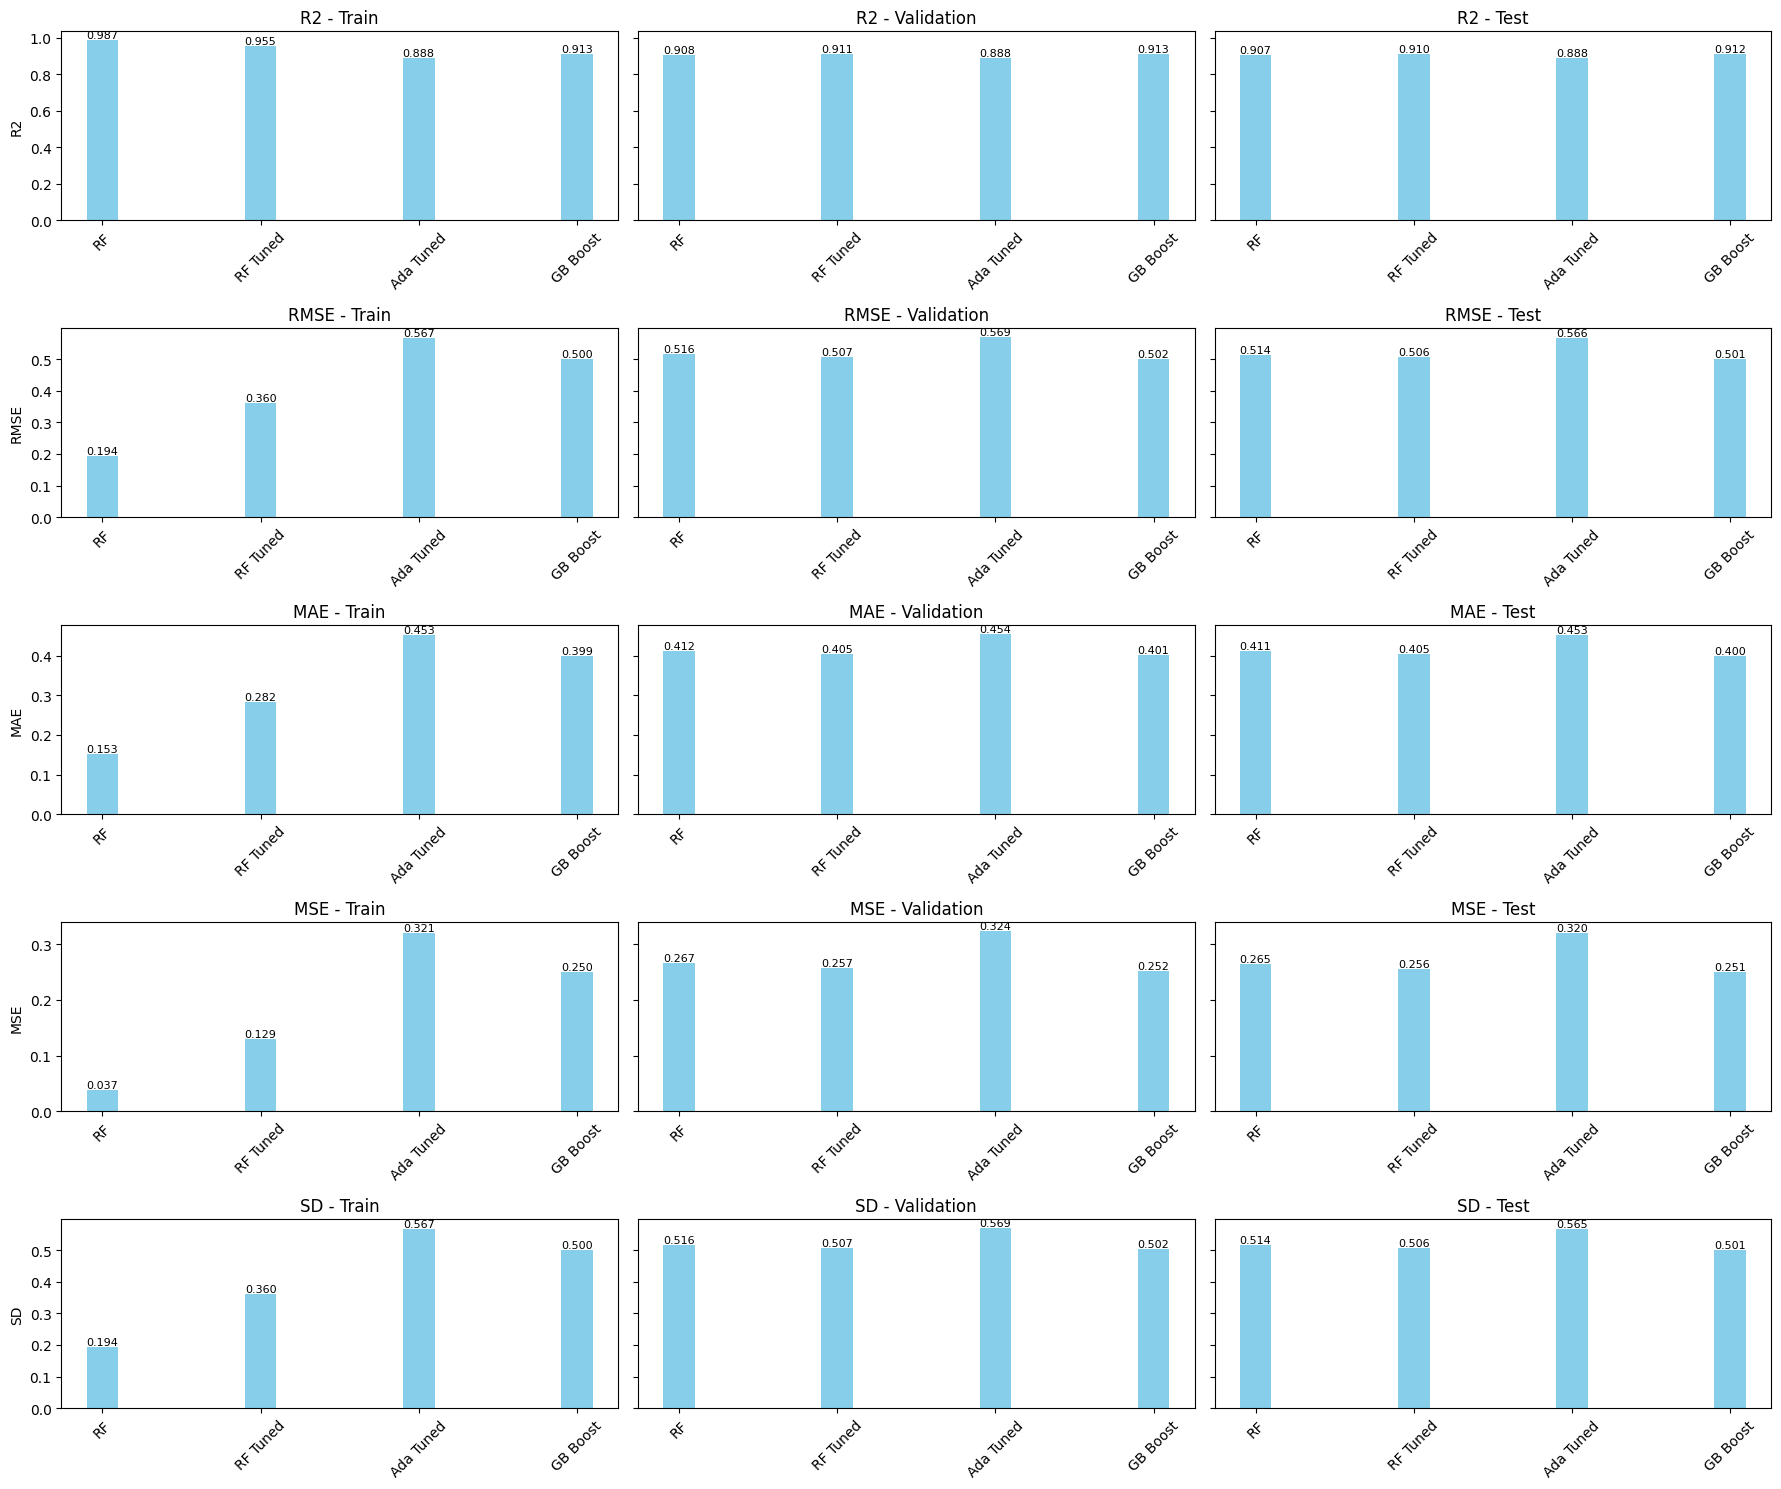

In [ ]:
data = {
    'Model': ['RF', 'RF Tuned', 'Ada Tuned', 'GB Boost'],
    'Train R2': [0.9870, 0.9550, 0.8883, 0.9132],
    'Validation R2': [0.9080, 0.9113, 0.8883, 0.9131],
    'Test R2': [0.9072, 0.9101, 0.8879, 0.9120],
    'Train RMSE': [0.1935, 0.3597, 0.5668, 0.4998],
    'Validation RMSE': [0.5163, 0.5070, 0.5688, 0.5018],
    'Test RMSE': [0.5144, 0.5062, 0.5655, 0.5008],
    'Train MAE': [0.1531, 0.2824, 0.4531, 0.3988],
    'Validation MAE': [0.4123, 0.4052, 0.4538, 0.4007],
    'Test MAE': [0.4113, 0.4046, 0.4527, 0.3998],
    'Train MSE': [0.0374, 0.1294, 0.3213, 0.2498],
    'Validation MSE': [0.2665, 0.2570, 0.3235, 0.2518],
    'Test MSE': [0.2647, 0.2562, 0.3197, 0.2508],
    'Train SD': [0.1935, 0.3597, 0.5667, 0.4998],
    'Validation SD': [0.5163, 0.5070, 0.5685, 0.5018],
    'Test SD': [0.5144, 0.5062, 0.5653, 0.5008]
}


perf_mat = pd.DataFrame(data)
perf_mat.set_index('Model', inplace=True)

metrics = ['R2', 'RMSE', 'MAE', 'MSE', 'SD']
stages = ['Train', 'Validation', 'Test']

fig, axes = plt.subplots(len(metrics), len(stages), figsize=(18, 15), sharey='row')
bar_width = 0.2
x = np.arange(len(perf_mat.index)) 

for i, metric in enumerate(metrics):
    for j, stage in enumerate(stages):
        ax = axes[i, j]
        vals = perf_mat[f'{stage} {metric}']
        ax.bar(x, vals, width=bar_width, color='skyblue')
        ax.set_xticks(x)
        ax.set_xticklabels(perf_mat.index, rotation=45)
        ax.set_title(f'{metric} - {stage}')
        for idx, val in enumerate(vals):
            ax.text(idx, val, f'{val:.3f}', ha='center', va='bottom', fontsize=8)
        if j == 0:
            ax.set_ylabel(metric)

plt.tight_layout()
plt.show()